In [1]:
import requests_cache
requests_cache.install_cache('cache', allowable_codes=[200, 404], allowable_methods=['GET', 'POST'])
import requests
import pandas as pd
from tqdm.auto import tqdm
import json
pd.set_option("display.max_columns", None)

price_history = pd.read_csv("price_history.csv")
price_history.sort_values(price_history.columns.tolist(), inplace=True)

all_products = []
new_prices = []
for page in tqdm(range(1, 84)):
    try:
        r = requests.get("https://www.woolworths.co.nz/api/v1/products", params={
            "target": "browse",
            "inStockProductsOnly": "false",
            "size": 120,
            "page": page
        }, headers={
            "x-requested-with": "??",
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36 Edg/129.0.0.0"
        }, timeout=5)
        r.raise_for_status()
        timestamp = int(r.created_at.timestamp())
        products = r.json()["products"]["items"]
        assert len(products) > 0, "No products"
        for product in products:
            sku = int(product["sku"])
            prices = price_history[price_history.SKU == sku].price
            if len(prices) == 0:
                last_price = None
            else:
                last_price = prices.iloc[-1]
            if product["price"]["salePrice"] != last_price:
                print(f"SKU {sku} price changed from {last_price} to {product['price']['salePrice']}")
                new_prices.append({
                    "SKU": sku,
                    "timestamp": timestamp,
                    "price": product["price"]["salePrice"]
                })
        all_products.extend(products)
    except Exception as e:
        raise
df = pd.json_normalize(all_products)
df.to_csv("products.csv", index=False)
df

  0%|          | 0/83 [00:00<?, ?it/s]

SKU 135344 price changed from 2.5 to 2.89
SKU 144329 price changed from 2.0 to 2.49
SKU 144607 price changed from 5.0 to 5.5
SKU 281082 price changed from 3.49 to 2.5
SKU 149681 price changed from 4.19 to 4.69
SKU 281197 price changed from 2.09 to 2.19
SKU 169792 price changed from 3.5 to 3.0
SKU 58643 price changed from 4.0 to 4.3
SKU 73034 price changed from 13.5 to 14.49
SKU 154340 price changed from 3.2 to 2.5
SKU 144522 price changed from 2.15 to 2.49
SKU 194870 price changed from 4.3 to 4.2
SKU 149374 price changed from 1.1 to 0.9
SKU 149885 price changed from 5.0 to 5.5
SKU 808766 price changed from 7.49 to 5.5
SKU 304977 price changed from 5.0 to 7.9
SKU 756910 price changed from 4.0 to 2.8
SKU 58645 price changed from 4.0 to 4.3
SKU 371547 price changed from 3.3 to 4.19
SKU 283277 price changed from 4.99 to 4.49
SKU 774152 price changed from 9.99 to 7.4
SKU 149779 price changed from 7.0 to 7.5
SKU 337557 price changed from 3.5 to 5.79
SKU 567139 price changed from 3.0 to 3.46


,type,name,barcode,variety,brand,slug,sku,unit,selectedPurchasingUnit,stockLevel,eachUnitQuantity,averageWeightPerUnit,hasShopperNotes,productTag,departments,subsAllowed,supportsBothEachAndKgPricing,adId,brandSuggestionId,brandSuggestionName,priceUnitLabel,availabilityStatus,onlineSample,onlineSampleRealProductMapId,price.originalPrice,price.salePrice,price.savePrice,price.savePercentage,price.canShowSavings,price.hasBonusPoints,price.isClubPrice,price.isSpecial,price.isNew,price.canShowOriginalPrice,price.discount,price.total,price.isTargetedOffer,price.averagePricePerSingleUnit,price.isBoostOffer,price.purchasingUnitPrice,price.orderedPrice,price.isUsingOrderedPrice,price.currentPricingMatchesOrderedPricing,price.extendedListPrice,price.originalAveragePricePerSingleUnit,images.small,images.big,quantity.min,quantity.max,quantity.increment,quantity.value,quantity.quantityInOrder,quantity.purchasingQuantityString,size.cupListPrice,size.cupPrice,size.cupMeasure,size.packageType,size.volumeSize,productTag.tagType,productTag.multiBuy,productTag.bonusPoints,productTag.additionalTag.name,productTag.additionalTag.link,productTag.additionalTag.imagePath,productTag.additionalTag.linkTarget,productTag.additionalTag.altText,productTag.targetedOffer,productTag.boostOffer,productTag.multiBuy.quantity,productTag.multiBuy.value,productTag.multiBuy.link,productTag.multiBuy.multiCupValue,productTag.additionalTag
0,Product,fresh fruit bananas yellow,9354829000064,yellow,fresh fruit,fresh-fruit-bananas-yellow,133211,Kg,None,3,None,0.25,None,NaN,"[{'id': 1, 'name': 'Fruit & Veg'}]",False,True,None,None,None,None,In Stock,None,0,3.49,3.49,0.00,0.0,True,False,False,False,False,True,None,None,False,0.87,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/1...,https://assets.woolworths.com.au/images/2010/1...,0.2,100.0,0.2,None,None,None,3.49,3.49,1kg,loose,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Product,fresh vegetable cucumbers telegraph,9421901390013,telegraph,fresh vegetable,fresh-vegetable-cucumbers-telegraph,281455,Each,None,3,None,NaN,None,NaN,"[{'id': 1, 'name': 'Fruit & Veg'}]",False,False,None,None,None,None,In Stock,None,0,1.50,1.50,0.00,0.0,True,False,False,False,False,True,None,None,False,NaN,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/2...,https://assets.woolworths.com.au/images/2010/2...,1.0,100.0,1.0,None,None,None,3.19,1.50,1ea,,,Other,NaN,NaN,Fresh Deals,,/Content/PromotionTags/F24_Fresh_deal.png,_self,Fresh Deals,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Product,woolworths butter salted,9300633725082,salted,woolworths,woolworths-butter-salted,827847,Each,None,3,None,NaN,None,NaN,"[{'id': 4, 'name': 'Fridge & Deli'}]",False,False,None,None,None,None,In Stock,None,0,7.19,7.19,0.00,0.0,True,False,False,False,False,True,None,None,False,NaN,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/8...,https://assets.woolworths.com.au/images/2010/8...,1.0,4.0,1.0,None,None,None,1.44,1.44,100g,None,500g,Other,NaN,NaN,Countdown's Own,/shop/productgroup/80842,/Content/PromotionTags/F24_Own_brand.png,_self,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Product,fresh vegetable carrots,9414742351053,,fresh vegetable,fresh-vegetable-carrots,135344,Kg,None,3,None,0.15,None,NaN,"[{'id': 1, 'name': 'Fruit & Veg'}]",False,True,None,None,None,None,In Stock,None,0,2.89,2.89,0.00,0.0,True,False,False,False,False,True,None,None,False,0.43,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/1...,https://assets.woolworths.com.au/images/2010/1...,0.1,100.0,0.1,None,None,None,2.89,2.89,1kg,loose,per kg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Product,woolworths milk standard,9414742036509,standard,woolworths,woolworths-milk-standard,282768,Each,None,3,None,NaN,None,NaN,"[{'id': 17, 'name': 'Easter'}]",False,False,None,None,None,None,In Stock,None,0,6.75,6.75,0.00,0.0,True,False,False,False,False,True,None,None,F

In [2]:
price_history = pd.concat([price_history, pd.DataFrame(new_prices)], ignore_index=True).sort_values(price_history.columns.tolist())
price_history

,SKU,timestamp,price
0,25,1728880327,3.99
1,168,1728880353,2.60
2,326,1728880348,4.30
3,579,1728880353,1.00
4,579,1729443688,2.00
...,...,...,...
91064,6000613,1738515793,9.90
86108,6003489,1737997424,8.00
91343,6004091,1738515806,7.00
86109,6004094,1738343001,6.80


In [3]:
price_history.groupby("SKU").size().value_counts()

1     2586
15    1243
16     751
14     705
2      703
3      691
13     607
9      530
12     470
7      458
10     456
11     454
5      401
8      386
4      304
6      288
17     207
18     100
19      16
22       2
21       1
dtype: int64

In [4]:
delta = price_history.groupby("SKU").price.diff()
delta.describe()

count    80023.000000
mean         0.006959
std          2.490573
min        -28.990000
25%         -1.090000
50%          0.030000
75%          1.090000
max         28.990000
Name: price, dtype: float64

<Axes: ylabel='Frequency'>

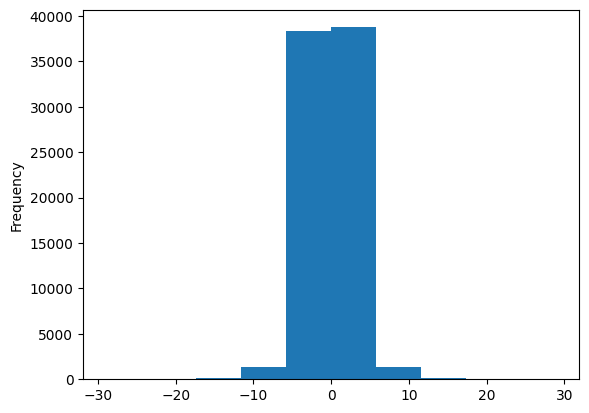

In [5]:
delta.plot.hist()

In [6]:
price_history.to_csv("price_history.csv", index=False)